# import data

In [179]:
import numpy as np

with open('datasets/collaboration.edgelist.txt', 'r') as f:
    txt = f.readlines()
    txt = list(map(lambda x: x.replace('\n', '').split('\t'), txt))
    txt = list(map(lambda x: [int(x[0]), int(x[1])], txt))
    txt = np.array(txt)

num_node = np.max(txt) + 1

from scipy.sparse import dok_matrix, csr_matrix
from scipy import float32
S = dok_matrix((num_node,num_node), dtype=float32)
for i in txt:
    S[i[0],i[1]] = 1.
S = S.tocsr()

# p1

### (a) degree distribution

Wall time: 20 ms


Text(0.5, 1.0, 'degree distribution plot')

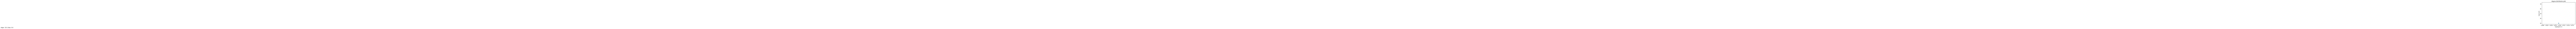

In [149]:
%%time

degrees = np.asarray(S.sum(axis=1)).reshape(-1)

from collections import Counter

degree_counts = np.array([[np.log(d + 1), np.log(c)] for (d, c) in  Counter(degrees).items()])

import matplotlib.pyplot as plt

def least_squares(x, y):
    x_ = np.concatenate((x, np.ones(x.shape)), axis=1)
    return np.dot(np.linalg.inv(np.dot(x_.T, x_)), np.dot(x_.T, y))

x, y = degree_counts[:,0].reshape(-1,1), degree_counts[:,1].reshape(-1,1)

[slope, bias] = least_squares(x, y).reshape(-1).tolist()

def infer_y(x, slope, bias):
    return x * slope + bias

v_infer_y = np.vectorize(lambda x: infer_y(x, slope, bias))

inferred_y = v_infer_y(x)

plt.scatter(x, y)
plt.plot(x, inferred_y, c='orange')
plt.text(.1, .1, 'slope: {}, bias: {}'.format(round(slope, 2), round(bias, 2)), 
         fontsize=12)
plt.xlabel('log(degree+1)')
plt.ylabel('log(count)')
plt.title('degree distribution plot')
plt.show()

### (b) clustering coefficients

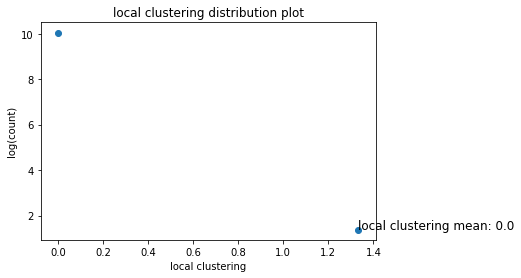

Wall time: 162 ms


In [148]:
%%time

S_3 = S.dot(S).dot(S)

clusterings = np.nan_to_num(S_3.diagonal() / (degrees * (degrees - 1)))

clustering_mean = np.mean(clusterings)

clustering_counts = np.array([[cl, np.log(c)] \
    for (cl, c) in  Counter(clusterings).items()])




x, y = clustering_counts[:,0].reshape(-1,1), \
    clustering_counts[:,1].reshape(-1,1)

plt.scatter(x, y)
plt.text(x[0], y[0]  , 'local clustering mean: {}'.format(round(clustering_mean,2)), 
         fontsize=12)
plt.xlabel('local clustering')
plt.ylabel('log(count)')
plt.title('local clustering distribution plot')
plt.show()

### (c) shortest path distribution

100%|██████████████████████████████████████████████████████████████████████████| 23133/23133 [00:19<00:00, 1162.52it/s]


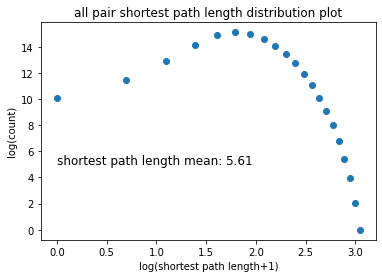

Wall time: 25 s


In [101]:
%%time

from collections import defaultdict

row_nonzero, col_nonzero = S.nonzero()

aja_list = defaultdict(list)

for ind, i in enumerate(row_nonzero):
    aja_list[i].append(col_nonzero[ind])

from collections import deque

from tqdm import tqdm

all_dist = defaultdict(dict)
for i in tqdm(range(num_node)):
    all_dist[i][i] = 0
    neighs = aja_list[i]
    queue = deque()
    for j in neighs:
        all_dist[i][j] = 1
        queue.append((j, 1))
    if queue:
        while queue:
            cur_node, cur_dis = queue.popleft()
            neighs = aja_list[cur_node]
            for j in neighs:
                if j not in all_dist[i]:
                    all_dist[i][j] = cur_dis + 1
                    queue.append((j, cur_dis + 1))
 
all_dist_vals = []
for i in all_dist:
    temp = all_dist[i]
    for j in temp:
        all_dist_vals.append(temp[j])

shortest_path_mean = np.mean(all_dist_vals)

inf_dist_count = num_node * num_node - len(all_dist_vals)

all_dist_val_counts = Counter(all_dist_vals)
# all_dist_val_counts[num_node] = inf_dist_count

all_dist_val_counts = np.array([[np.log(pl + 1), np.log(c)] \
    for (pl, c) in  all_dist_val_counts.items()])


x, y = all_dist_val_counts[:,0].reshape(-1,1), all_dist_val_counts[:,1].reshape(-1,1)

plt.scatter(x, y)
plt.text(x[0], y[0] // 2, 'shortest path length mean: {}'.format(round(shortest_path_mean,2)), 
         fontsize=12)
plt.xlabel('log(shortest path length+1)')
plt.ylabel('log(count)')
plt.title('all pair shortest path length distribution plot')
plt.show()

### (d) number of connected components, the portion of nodes that are in the GCC

In [102]:
%%time

all_comp = {}
base_comp = 0
for i in tqdm(range(num_node)):
    if i not in all_comp:
        all_comp[i] = base_comp
        neighs = aja_list[i]
        queue = deque()
        for j in neighs:
            all_comp[j] = base_comp
            queue.append((j, base_comp))
        if queue:
            while queue:
                cur_node, cur_dis = queue.popleft()
                neighs = aja_list[cur_node]
                for j in neighs:
                    if j not in all_comp:
                        all_comp[j] = base_comp
                        queue.append((j, base_comp))
        base_comp += 1


components = np.array(list(all_comp.values()))

component_counter = Counter(components)

print('number of connected component: ', len(component_counter))
print('portion of nodes in giant connected component: ', round(max(component_counter.values()) / num_node, 2))

100%|████████████████████████████████████████████████████████████████████████| 23133/23133 [00:00<00:00, 269704.78it/s]


number of connected component:  4650
portion of nodes in giant connected component:  0.05
Wall time: 101 ms


### (e) eigenvalue distribution (compute the spectral gap)

In [103]:
%%time

import scipy

from scipy.sparse import linalg, diags

degree_diagonal = diags(degrees, 0)

laplacian = degree_diagonal  - S

eigen_vals = linalg.eigsh(laplacian, k = num_node-1, return_eigenvectors=False)

eigen_vals = sorted(eigen_vals, reverse=True)

pos_eigen = [i for i in eigen_vals if i > 0]
eigen_gap = pos_eigen[-1]

import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(eigen_vals)
plt.title('laplacian eigenvalue distribution')
plt.text(40, .025, 'eigengap: {}'.format(round(eigen_gap,2)))
plt.xlabel('eigenvalue')
plt.ylabel('density')
plt.show()

KeyboardInterrupt: 

### (f) degree correlations (plot as scatter di vs dj , also report the overall correlation).

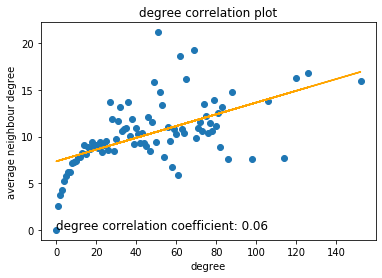

Wall time: 180 ms


In [104]:
%%time

degree_vector = csr_matrix(degrees.reshape(-1, 1))

avg_neighbor_degree = np.nan_to_num(np.asarray(S.dot(degree_vector) / degree_vector)).reshape(-1)

degree_correlation = defaultdict(list)
for ind, i in enumerate(degrees):
    degree_correlation[int(i)].append(avg_neighbor_degree[ind])
x = []
y = []
for i in degree_correlation:
    x.append(i)
    y.append(np.mean(degree_correlation[i]))
x = np.array(x) 
y = np.array(y) 

[slope, bias] = least_squares(x.reshape(-1,1), y.reshape(-1,1)).reshape(-1).tolist()

inferred_y = v_infer_y(x)

plt.scatter(x,y)
plt.plot(x, inferred_y, c='orange')
plt.title('degree correlation plot')
plt.xlabel('degree')
plt.ylabel('average neighbour degree')
plt.text(.1, .1, 'degree correlation coefficient: {}'.format(round(slope, 2)), 
         fontsize=12)
plt.show()

### (g) degree-clustering coefficient relation (plot as scatter di vs ci)

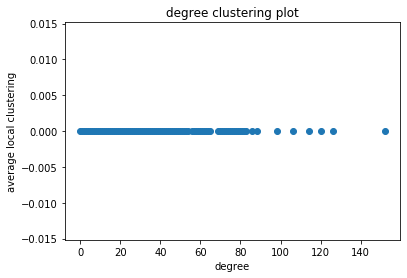

Wall time: 155 ms


In [105]:
%%time

degree_clustering = defaultdict(list)
for ind, i in enumerate(degrees):
    degree_clustering[int(i)].append(clusterings[ind])
x = []
y = []
for i in degree_clustering:
    x.append(i)
    y.append(np.mean(degree_clustering[i]))
x = np.array(x) 
y = np.array(y) 

plt.scatter(x,y)
plt.title('degree clustering plot')
plt.xlabel('degree')
plt.ylabel('average local clustering')
plt.show()

# p2

In [181]:
m = S.nnz // num_node
initial_num_node = max(4, m)
t = num_node - initial_num_node

In [182]:
S_ba = dok_matrix((num_node,num_node), dtype=float32)

degree_ba = np.zeros(num_node)

idx_ba = np.array(list(range(num_node)))

for i in range(initial_num_node):
    degree_ba[i] += initial_num_node
    for j in range(initial_num_node):
        S_ba[i,j] = 1
        S_ba[j,i] = 1

for i in tqdm(range(initial_num_node, initial_num_node + t)):
    ns = np.random.choice(idx_ba, size=m, p=degree_ba/np.sum(degree_ba), replace=False).tolist()
    for n in ns:
        degree_ba[n] = degree_ba[n] + 1
        S_ba[i,n] = 1
        S_ba[n,i] = 1
    degree_ba[i] += m

100%|██████████████████████████████████████████████████████████████████████████| 23129/23129 [00:11<00:00, 2090.64it/s]


In [183]:
S_ba = S_ba.tocsr()